In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv("train_comments.csv")
test = pd.read_csv("test_comments.csv")

In [3]:
train.head()

id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [4]:

train.describe()

malignant  highly_malignant           rude         threat  \
count  159571.000000     159571.000000  159571.000000  159571.000000   
mean        0.095844          0.009996       0.052948       0.002996   
std         0.294379          0.099477       0.223931       0.054650   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   

               abuse         loathe  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [5]:
train.shape

(159571, 8)

In [6]:
test.shape

(153164, 2)

In [7]:
# Subsetting labels from the training data
train_labels = train[['malignant', 'highly_malignant',
                      'rude', 'threat', 'abuse', 'loathe']]
label_count = train_labels.sum()

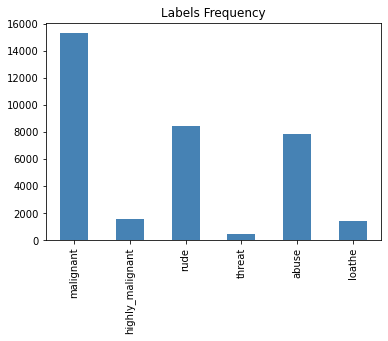

In [8]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

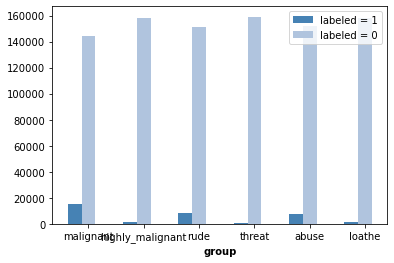

In [9]:
barWidth = 0.25

bars1 = [sum(train['malignant'] == 1), sum(train['highly_malignant'] == 1), sum(train['rude'] == 1), sum(train['threat'] == 1),
         sum(train['abuse'] == 1), sum(train['loathe'] == 1)]
bars2 = [sum(train['malignant'] == 0), sum(train['highly_malignant'] == 0), sum(train['rude'] == 0), sum(train['threat'] == 0),
         sum(train['abuse'] == 0), sum(train['loathe'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['malignant', 'highly_malignant','rude', 'threat', 'abuse', 'loathe'])
plt.legend()
plt.show()


In [10]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
train[train.malignant == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

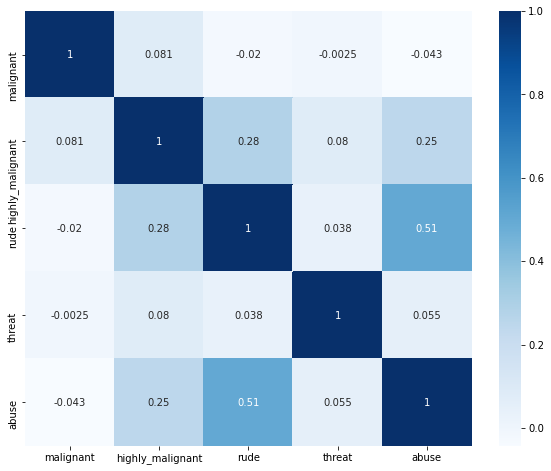

In [12]:
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

In [13]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

In [ ]:
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

In [ ]:
test_labels = ["malignant", "highly_malignant", "rude",
               "threat", "abuse", "loathe"]

In [ ]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [ ]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [ ]:
vector.get_feature_names()[0:20]

In [ ]:
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [ ]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [ ]:
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [ ]:

# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

In [ ]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [ ]:
 Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [ ]:

# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

In [ ]:

# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

In [ ]:

# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

In [ ]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [ ]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

In [ ]:

# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [ ]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

In [ ]:
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [ ]:
score_df = []
for pipe in pipelines:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        start = timer()
        pipe.fit(X_train, train[label])
        train_time = timer() - start
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        recall_values.append(recall_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        training_time.append(train_time)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]

    hamming_loss_score = hamming_loss(
        test_y[test_y['toxic'] != -1].iloc[:, 1:7], predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]
    score_df.append(val)

In [ ]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss', 'Training_Time']
scores

In [ ]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

In [ ]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

In [ ]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_clf = lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='warn',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)

tunned_model_score_df = []
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [ ]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

In [ ]:

ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [ ]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for idx, label in enumerate(test_labels):
        start = timer()
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

In [ ]:
boosting_score = pd.DataFrame(boosting_score_df,)
boosting_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Traing_Time']
boosting_score